In [1]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(101)

Let's say we have some data $y = f(x)$, where $f(x)$ is an unknown function. The aim of this excercise is to employ Bayesian Inference and obtain the parameters of $f(x)$.

For this specific example the 'real' function will be:
$$ Y \sim N(B + W_{1}.X_{1} + W_{2}.X_{2} + W_{3}.X_{3}, \sigma)$$

In [2]:
def build_data(B=10, W=[3,5,15], sigma=4.0):
    
    # generating 100 samples from U[0,1] and then scaling them by factor of 50
    x = 50*np.random.rand(100,3)
    
    # generating y
    y = np.sum(B + W * x, axis=1)
    
    # adding gaussian noise to y with std=sigma
    y = np.random.normal(y, scale=sigma)
    
    return x,y

x,y = build_data()

The next thing we need to do is to define our Stan model, [Stan Reference Manual](http://mc-stan.org/users/documentation/):

In [3]:
def stan_model():
    model = """
        data {
            int<lower=0> N; //number of observations
            int<lower=0> K; //number of predictors
            matrix[N, K] x; //predictor matrix
            vector[N] y;    //outcome vector
        }

        parameters {
            real B;         //intercept
            vector[K] W;    //weights for the predictors
            real<lower=0> sigma; //error scale
        }

        model {
            y ~ normal(B + x * W, sigma); //likelihood
        }
    """
    
    return model

model = stan_model()

Once this is done the next step is to convert our 'observed' data into Stan-friendly format, compile and train the model:

In [4]:
# converting the data into a dictionary
data = {'N': len(x), 'K': 3, 'x': x, 'y': y}

# compiling the mdoel
sm = pystan.StanModel(model_code=model)

# training the model and generating samples
### iter - the total number of samples that will be generated from each Markov chain
### chains - the number of chains from which samples will be combined to form the posterior distribution
### warmup - the amount of samples that will be discarded from the beginning of each chain
### thin - an interval in sampling at which samples are retained
fit = sm.sampling(data=data, iter=5000, chains=250, warmup=500, thin=5, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ae816deadc02a29347c354e96612ba96 NOW.
C:\Users\vasil\AppData\Local\Continuum\anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\vasil\AppData\Local\Temp\tmp20zlbcqo\stanfit4anon_model_ae816deadc02a29347c354e96612ba96_8366344691872365073.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Diagnostics of the model:

In [5]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
B,28.815194,0.003279,1.542243,25.785404,27.783432,28.820957,29.850382,31.837199,221279.993645,1.000188
W[1],3.036952,0.000069,0.032812,2.972384,3.014941,3.036912,3.059050,3.101306,224683.171049,1.000006
W[2],5.013221,0.000067,0.031553,4.951331,4.992150,5.013216,5.034298,5.075353,224455.949214,1.000087
W[3],14.999258,0.000069,0.032611,14.935309,14.977376,14.999228,15.021075,15.063424,224100.911399,1.000097
sigma,4.544820,0.000707,0.333946,3.946838,4.311606,4.524735,4.756961,5.254442,222952.934956,1.000280
lp__,-199.119481,0.003481,1.622830,-203.133252,-199.947978,-198.786866,-197.928096,-196.977113,217278.521827,0.999975


In [6]:
B = fit['B']
W1 = fit['W'][:,0]
W2 = fit['W'][:,1]
W3 = fit['W'][:,2]
sigma = fit['sigma']

So from the diagnostics we can observe that we have pretty good estimates for $B$, $W$ and $\sigma$. As you know a solution to a Bayesian Inference problem is a **probability distribution** for the unknown parameters.

C:\Users\vasil\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


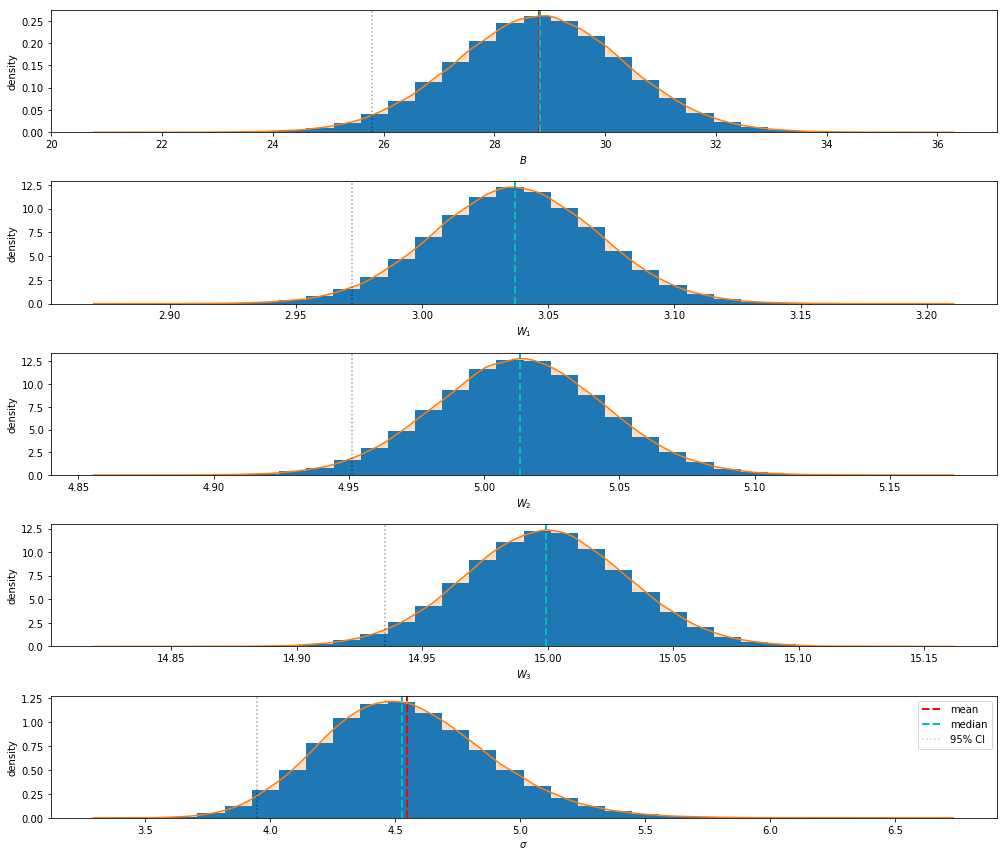

In [7]:
def distribution(params, param_names):
    
    mean = []
    median = []
    conf_int = []
    
    for param in params:
        mean.append(np.mean(param))
        median.append(np.median(param))
        conf_int.append((np.percentile(param, 2.5), np.percentile(param, 97.5)))
        
    plt.rcParams['figure.figsize'] = (14,12)
    for i in range(0,len(params)):
        plt.subplot(len(params), 1, i+1)
        plt.hist(params[i], bins=30, density=True)
        sns.kdeplot(params[i], shade=True)
        plt.xlabel(param_names[i])
        plt.ylabel('density')
        plt.axvline(mean[i], color='r', lw=2, linestyle='--',label='mean')
        plt.axvline(median[i], color='c', lw=2, linestyle='--',label='median')
        plt.axvline(conf_int[i][0], linestyle=':', color='k', alpha=0.2, label='95% CI')
        plt.axvline(conf_int[i][0], linestyle=':', color='k', alpha=0.2)
        
    plt.gcf().tight_layout()
    plt.legend()

# plotting the probability distributions of the variables
distribution([B,W1,W2,W3,sigma], [r'$B$', r'$W_{1}$', r'$W_{2}$', r'$W_{3}$', r'$\sigma$'])